### Import Libraries

In [55]:
import pandas as pd
import warnings
import logging
import math
import random
import os
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
##from pgmpy.models import BayesianNetwork
from sklearn.ensemble import IsolationForest
#from pgmpy.inference import VariableElimination
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
#from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Load Dataset

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:

base_x = pd.read_csv('/content/drive/MyDrive/dataset/Base.csv')
base_x.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

In [164]:
base = base_x.sample(frac=0.1, random_state=1)

In [165]:
display(base['fraud_bool'].value_counts())
fraud = base[base['fraud_bool']==1]
legit = base[base['fraud_bool']==0]
# fraction of fraud data against legit
outlier_fraction = len(fraud)/float(len(legit))
print(f'\nFraction of fraudulant accounts: {outlier_fraction}')
print('Fraud Cases: {}'.format(len(fraud)))
print('Legitimate Cases: {}'.format(len(legit)))

fraud_bool
0    98861
1     1139
Name: count, dtype: int64


Fraction of fraudulant accounts: 0.01152122677294383
Fraud Cases: 1139
Legitimate Cases: 98861


In [166]:
base['housing_status'].value_counts()

housing_status
BC    37159
BB    26138
BA    16999
BE    16912
BD     2608
BF      153
BG       31
Name: count, dtype: int64

In [167]:
feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not.1 indiates fraud and0 indicates legit"
}

In [168]:
# split numerical and categorical features
num_features = base.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_features if base[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_features if base[feat].nunique() < thresh]

cat_feats = base.select_dtypes(exclude='number').columns.tolist()
target_feat = disc_feats[0]
disc_feats.remove(target_feat)

cont_feats.append(disc_feats[0])
disc_feats.remove(disc_feats[0])

print(f'Features: {base.shape[1]}\n\n\
Num features: {len(num_features)}\n\
{num_features}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Discrete: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

print(f'\n\nTarget feature: {target_feat}')

Features: 32

Num features: 27
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Continuous: 15
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'income']

Discrete: 11
['customer_age', 'email_is_fr

### Data Cleaning and Preparation

In [169]:
# Encoding Categorical Variables
def encode_columns(df, categorical):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in categorical:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    return df_encoded

# Encode the categorical and target columns
base_encoded = encode_columns(base, cat_feats)

In [170]:
base_encoded.shape

(100000, 32)

In [172]:
base_clean = base_encoded.replace(-1, pd.NA).dropna()
base_clean.shape

(19596, 32)

In [173]:
base_clean['fraud_bool'].value_counts()

fraud_bool
0    19540
1       56
Name: count, dtype: int64

In [175]:
from imblearn.over_sampling import SMOTE
import pandas as pd

X = base_clean.drop(target_feat, axis=1)
y = base_clean[target_feat]

# Calculate the number of fraud accounts after oversampling
n_legit = len(base_clean[base_clean['fraud_bool']==0])
n_fraud = 0.80 * n_legit

# Using SMOTE to oversample fraud accounts
smote = SMOTE(sampling_strategy={1: int(n_fraud)})
X_smote, y_smote = smote.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
base_smote = pd.concat([X_smote, y_smote], axis=1)
print(f'Shape of the resampled data: {base_smote.shape}')
print(base_smote['fraud_bool'].value_counts())


Shape of the resampled data: (35172, 32)
fraud_bool
0    19540
1    15632
Name: count, dtype: int64


## Exploratory Data Analysis

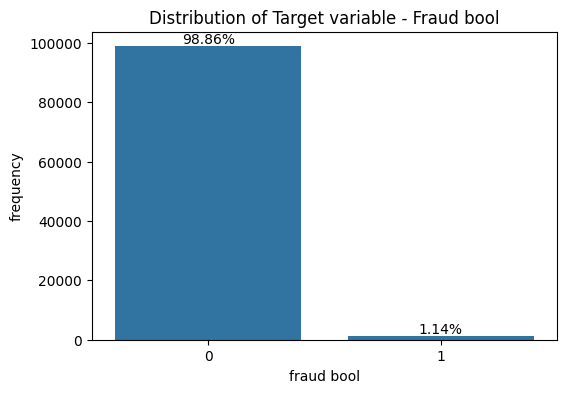

In [179]:
fig = plt.figure(figsize=(6,4))

# plot frequency of dependent variable
total_cnt = len(base)
ax = sns.countplot(x='fraud_bool', data=base)

for p in ax.patches:
    ax.annotate(f'{(p.get_height()/total_cnt)*100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

# Add titles and labels
ax.set_title('Distribution of Target variable - Fraud bool')
ax.set_xlabel('fraud bool')
ax.set_ylabel('frequency')

# Show the plot
plt.show();


In [181]:
def eda_cont_stats(feat, base):
    feature_stats = []

    for col in feat:
        missing_values = len(base[base[col] == -1])
        mean = base[col].mean()
        std = base[col].std()
        minimum = base[col].min()
        maximum = base[col].max()
        median = base[col].median()
        correlation = base_encoded.corr()['fraud_bool'][col]

        feature_stats.append({
            'Feature': col,
            'Missing Values': missing_values,
            'Mean': mean,
            'Standard Deviation': std,
            'Minimum': minimum,
            'Maximum': maximum,
            'Median': median,
            'Correlation': correlation
        })

    return feature_stats

# Create a DataFrame from the list of dictionaries
feature_stats = eda_cont_stats(cont_feats, base_smote)
base_stats = pd.DataFrame(feature_stats)


In [182]:
base_stats

Feature  Missing Values         Mean  \
0              name_email_similarity               0     0.401625   
1          prev_address_months_count               0    66.881463   
2       current_address_months_count               0    27.757610   
3                 days_since_request               0     2.789692   
4             intended_balcon_amount               0     9.979920   
5                       zip_count_4w               0  1478.847265   
6                        velocity_6h               0  5136.245595   
7                       velocity_24h               0  4824.490340   
8                        velocity_4w               0  4843.834338   
9               bank_branch_count_8w               0   166.471113   
10  date_of_birth_distinct_emails_4w               0     9.583788   
11                 credit_risk_score               0   139.567778   
12                 bank_months_count               0    16.906089   
13         session_length_in_minutes               0     9.585517   
14                            income               0     0.646510   

    Standard Deviation      Minimum       Maximum       Median  Correlation  
0             0.274226     0.000159      0.999999     0.363848    -0.034323  
1            63.001690     6.000000    371.000000    45.000000    -0.028807  
2            45.778397     0.000000    416.000000    10.390951     0.032112  
3             8.578487     0.000003     76.296635     0.015460     0.007688  
4            18.814283   -10.410875    111.396564    -0.644244    -0.024422  
5           908.185326     3.000000   6314.000000  1275.000000     0.011383  
6          3084.365665  -106.978297  16356.364000  4764.648357    -0.018423  
7          1478.415380  1423.654460   9409.114804  4802.126377    -0.007897  
8           992.500864  2989.524700   6988.564717  4946.459900    -0.013456  
9           375.103318     0.000000   2287.000000    14.000000    -0.014060  
10            5.095773     0.000000     37.000000     9.000000    -0.045683  
11           63.603908  -148.000000    369.000000   134.466350     0.070045  
12           10.818910     1.000000     32.000000    20.000000     0.000837  
13            9.489501     0.011926     78.772814     6.681833     0.004580  
14            0.255239     0.100000      0.900000     0.700000     0.046389

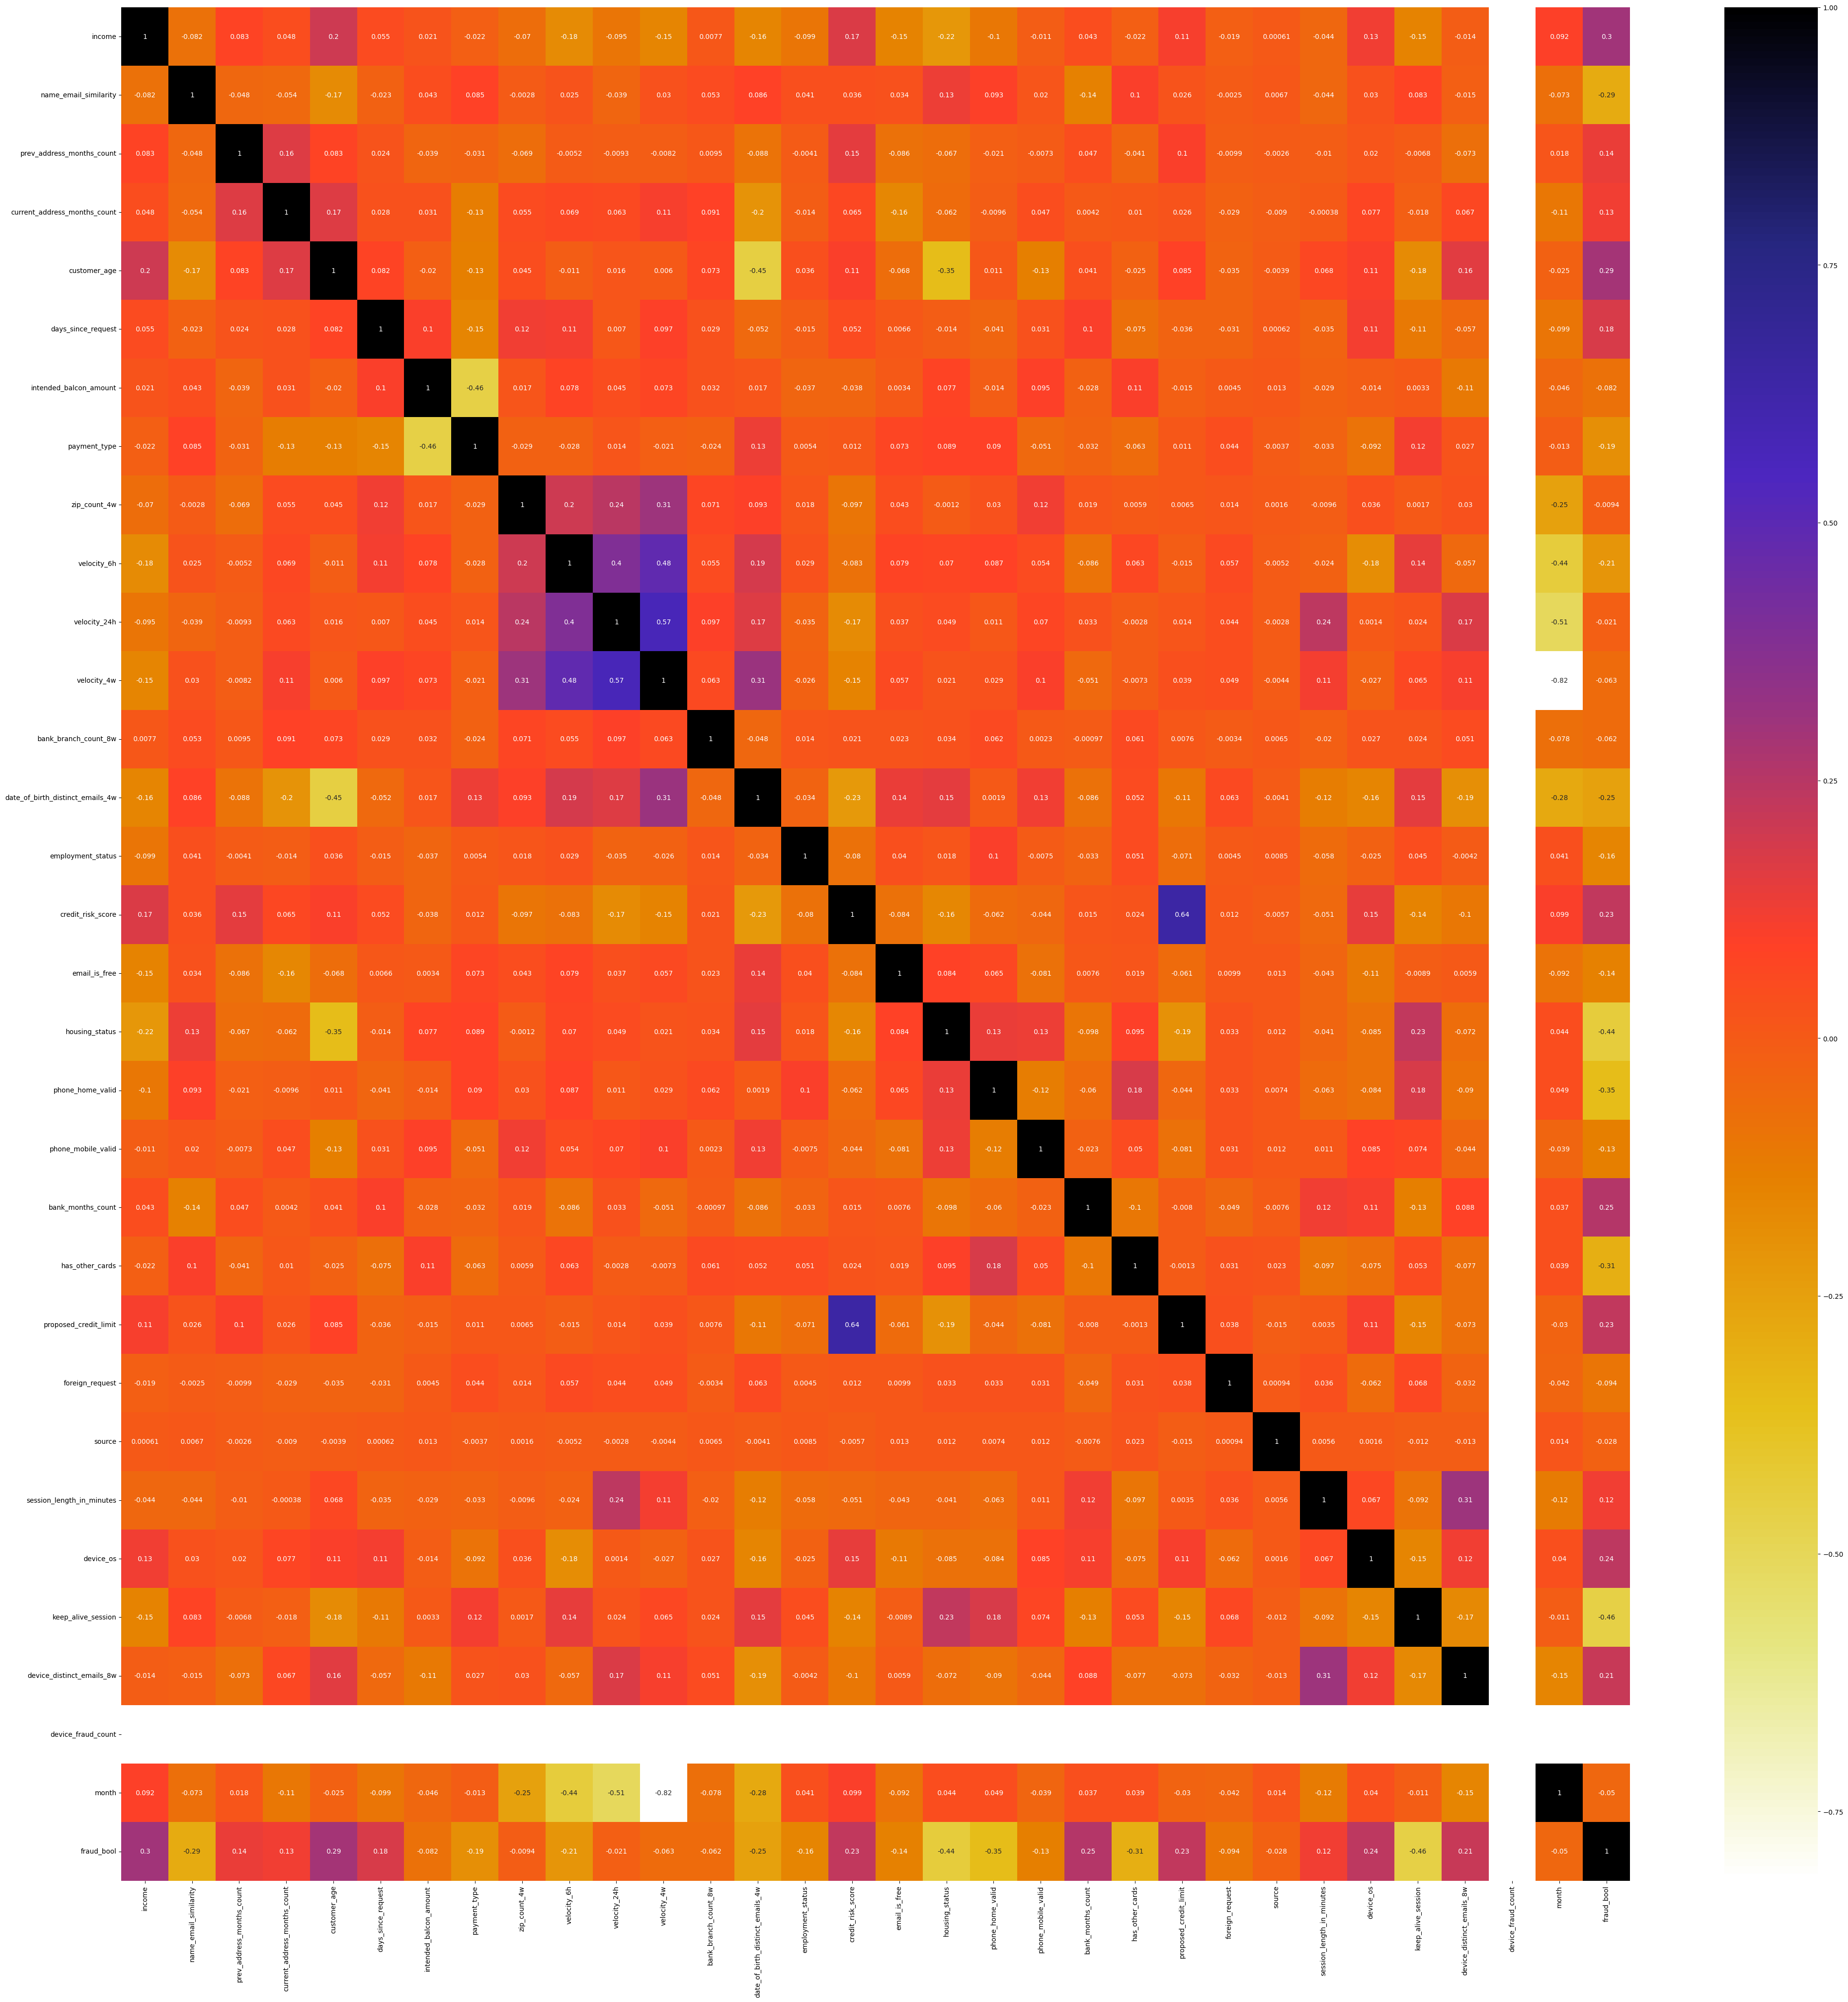

In [184]:
plt.figure(figsize=(50,50))
cor = base_smote.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [242]:
# method to find high correlated and redundant features
def correlation(df, threshold):
  col_corr = set()
  corr_matrix = df.corr()
  print(range(len(corr_matrix.columns)))
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr


In [243]:
corr_features = correlation(base_smote, 0.5)
print(len(corr_features))
print(corr_features)

range(0, 32)
3
{'month', 'velocity_4w', 'proposed_credit_limit'}




1.   Proposed credit limit is highly correlated with credit score
2.   Different credit payment plans are designated for different amounts transferred. Hence there is a high correlation between payment types and intended balcon amount
3. Month represents the volume of applications that may be depict seasonal trends. This is correlated with the velocity of applications for 6h, 2h or 4w
4. date_of_birth_distinct_emails_4w' has a higher correlation with customer age. Possible correlation would be younger age tend to have many email accounts.
5. Device fraud count does not have any influence on any features as all the samples have the value 0





In [212]:
def plot_correlation(features):
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(18, 6))
  feat1, feat2 = features
  print(f'{feat1}~{feat2}')
  sns.barplot(x=feat1, y=feat2, data=base_encoded, palette='viridis',orient='h')
  plt.xlabel(f'{feat1}')
  plt.ylabel(f'{feat2}')
  plt.title(f'Bar Plot of {feat1} vs. {feat2}')


In [215]:
def plot_correlation(features):
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(18, 6))
  feat1, feat2 = features
  print(f'{feat1}~{feat2}')
  sns.barplot(x=feat1, y=feat2, data=base, palette='viridis',orient='h')
  plt.xlabel(f'{feat1}')
  plt.ylabel(f'{feat2}')
  plt.title(f'Bar Plot of {feat1} vs. {feat2}')


date_of_birth_distinct_emails_4w~customer_age


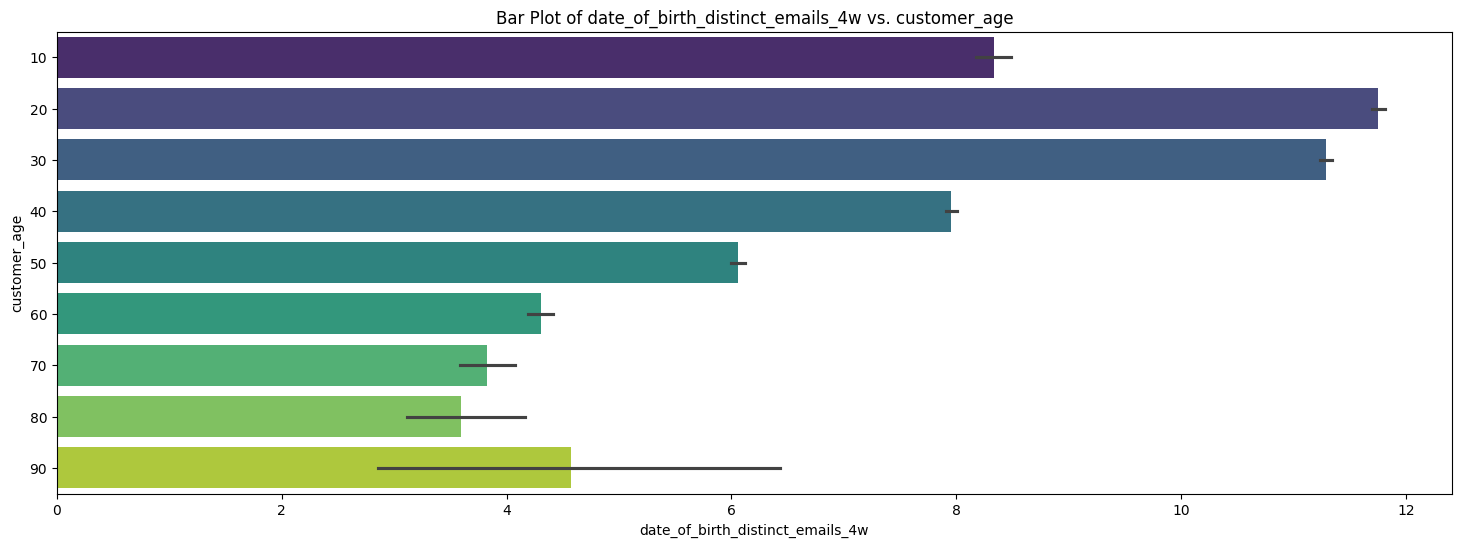

In [216]:
plot_correlation({'date_of_birth_distinct_emails_4w', 'customer_age'})

velocity_6h~month


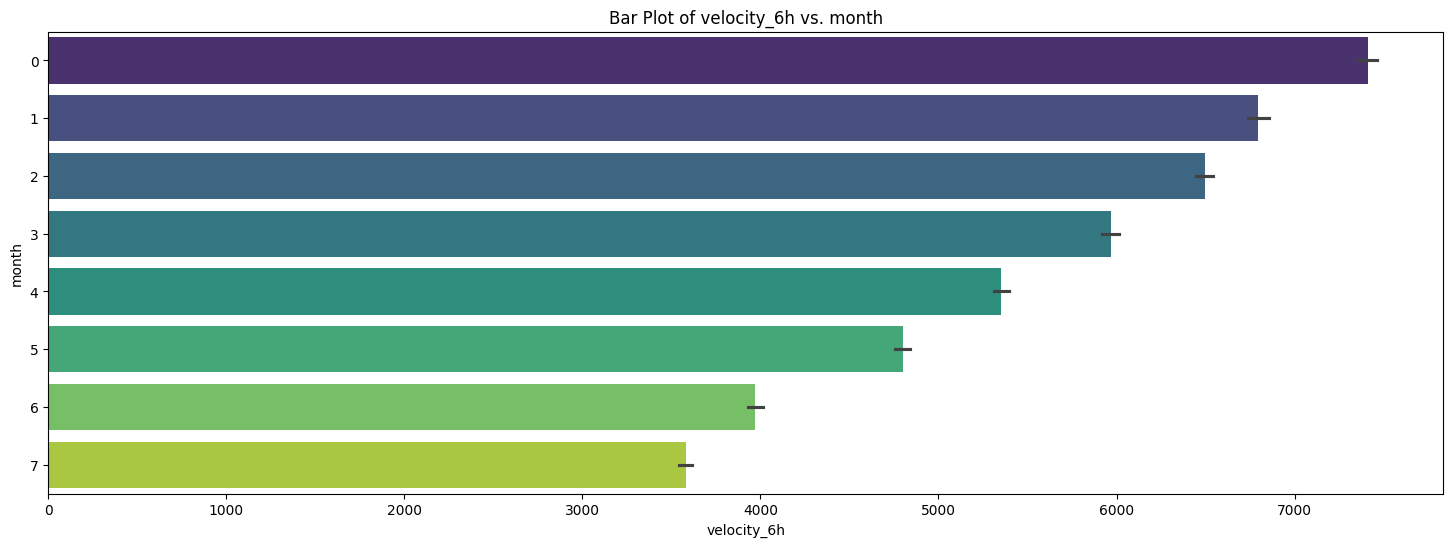

In [217]:
plot_correlation({'month','velocity_6h'})

velocity_24h~month


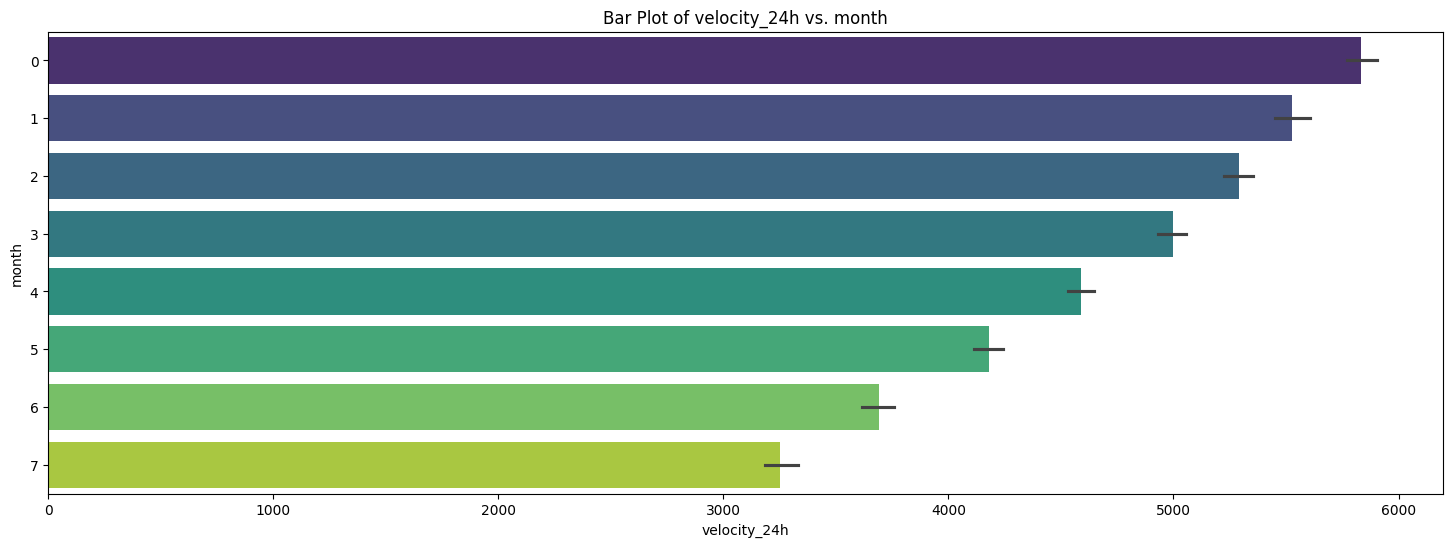

In [38]:
plot_correlation({'month','velocity_24h'})

credit_risk_score~proposed_credit_limit


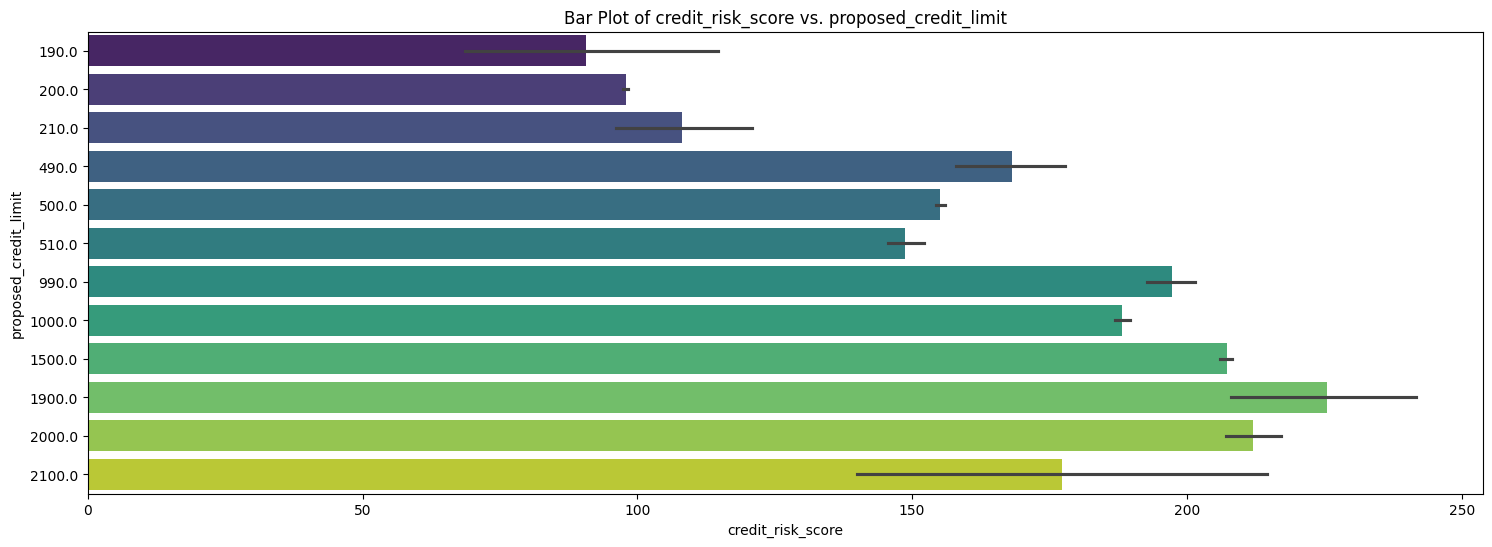

In [218]:
plot_correlation({'proposed_credit_limit','credit_risk_score'})

housing_status~payment_type


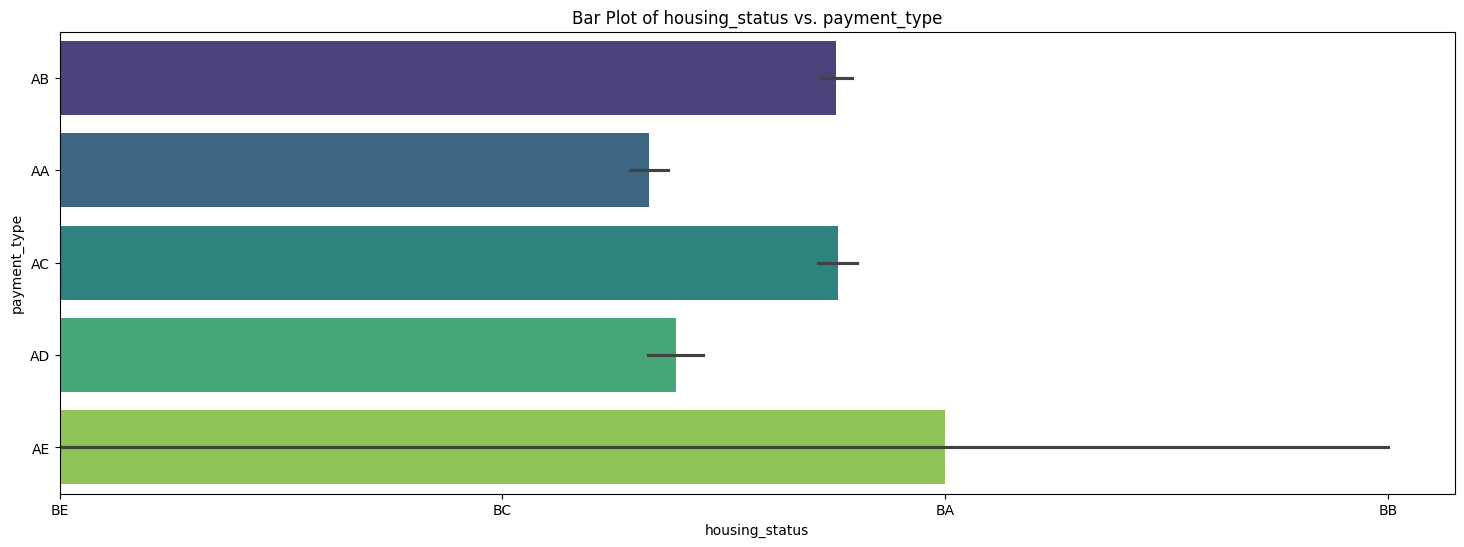

In [40]:
plot_correlation({'housing_status','payment_type'})

intended_balcon_amount~payment_type


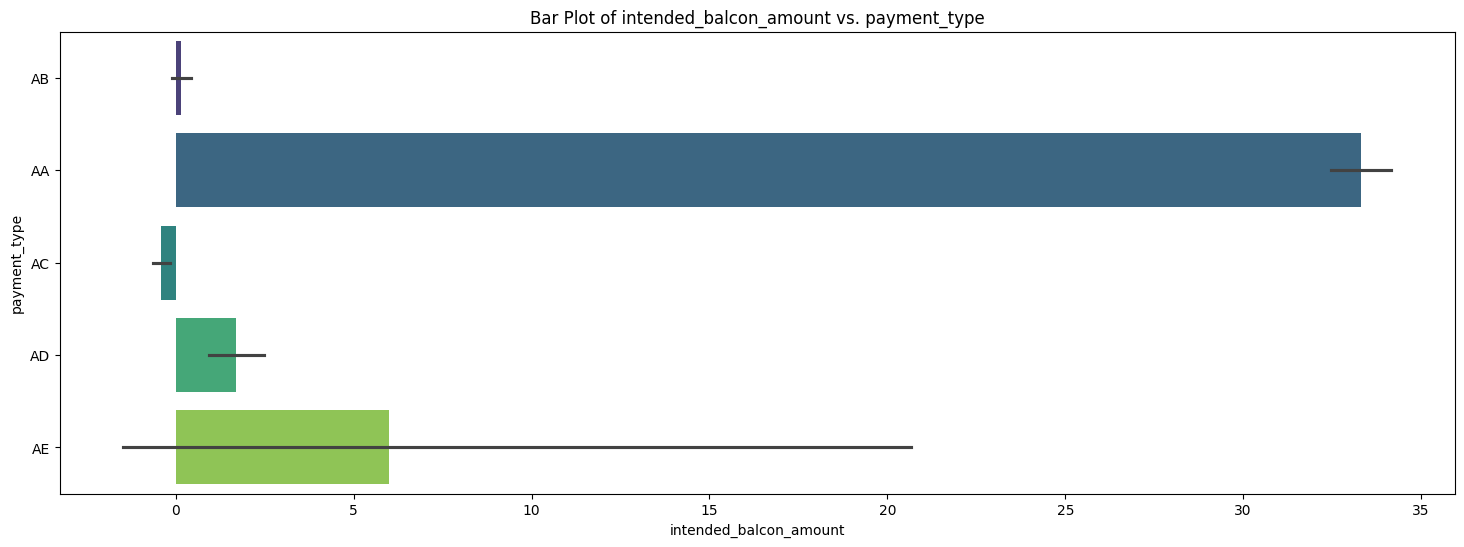

In [41]:
plot_correlation({'payment_type','intended_balcon_amount'})

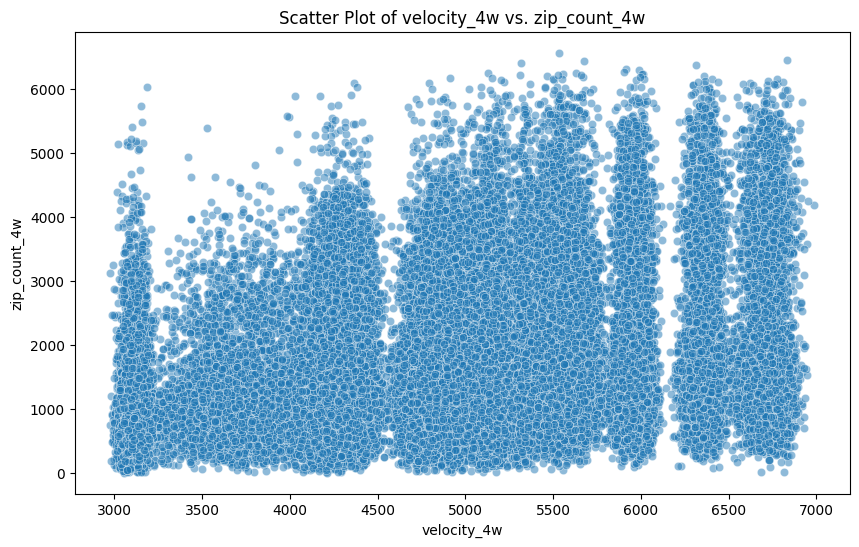

In [219]:
def plot_correlation_scatter(features):

    feat1, feat2 = features
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feat1, y=feat2, data=base_encoded, alpha=0.5)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f'Scatter Plot of {feat1} vs. {feat2}')
    plt.show()

plot_correlation_scatter({'zip_count_4w', 'velocity_4w'})

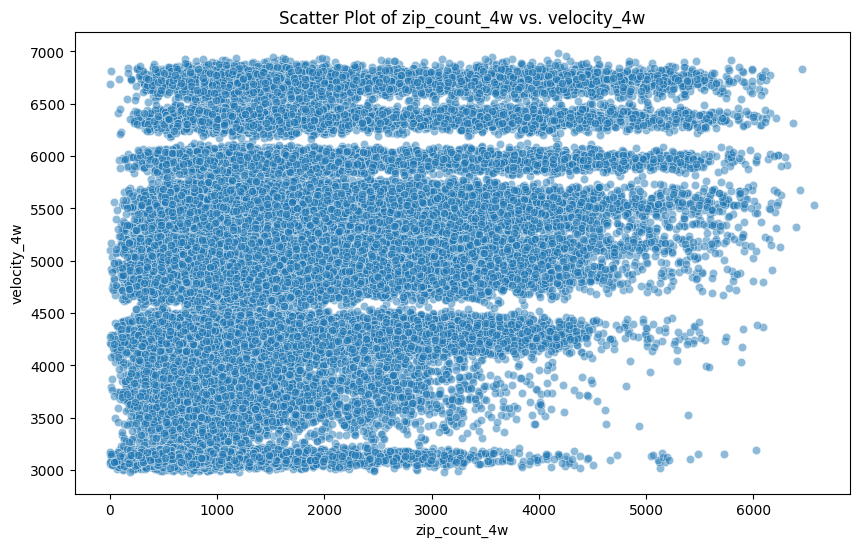

In [220]:
plot_correlation_scatter({'velocity_4w', 'zip_count_4w'})

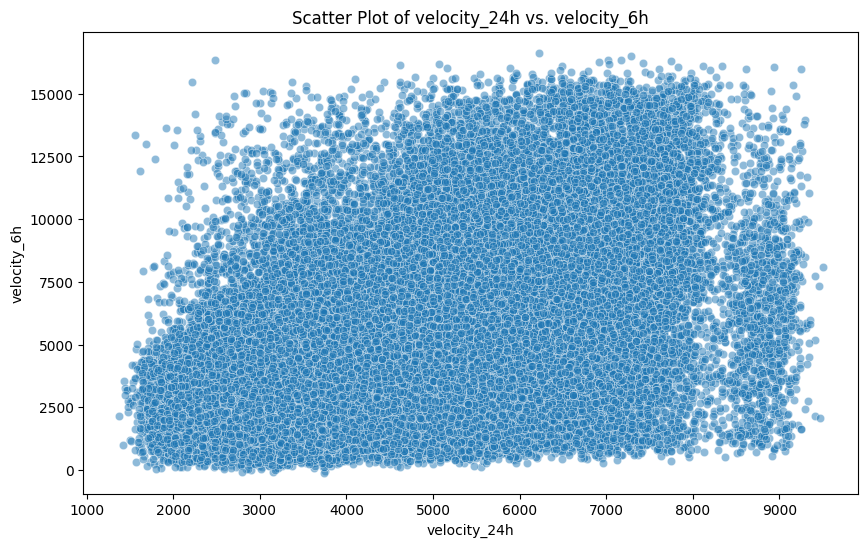

In [221]:
plot_correlation_scatter({'velocity_24h','velocity_6h'})

In [228]:
base_smote.head()

income  name_email_similarity prev_address_months_count  \
0     0.6               0.461974                      30.0   
1     0.9               0.388111                      31.0   
2     0.3               0.123415                       9.0   
3     0.2               0.069168                      21.0   
4     0.1               0.869321                      24.0   

  current_address_months_count  customer_age  days_since_request  \
0                          8.0            30            0.006326   
1                          2.0            50            0.010480   
2                         56.0            40            0.031242   
3                         39.0            30            0.000881   
4                         16.0            20            0.009921   

   intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
0               -0.916832             1          2162  1108.075600  ...   
1               -0.817218             1          2676  3849.725772  ...   
2               -1.623614             1           688  7503.932076  ...   
3               11.075005             0          1096  4052.377030  ...   
4               41.018283             1          1393  1586.570545  ...   

   proposed_credit_limit  foreign_request  source  session_length_in_minutes  \
0                  500.0                0       0                    5.50275   
1                 1500.0                0       0                   3.209488   
2                  500.0                0       0                   0.777212   
3                  200.0                0       0                  17.589304   
4                  500.0                0       0                   7.731688   

   device_os keep_alive_session  device_distinct_emails_8w  \
0          0                  0                        1.0   
1          3                  1                        1.0   
2          3                  1                        1.0   
3          3                  1                        1.0   
4          2                  0                        1.0   

   device_fraud_count  month  fraud_bool  
0                   0      3           0  
1                   0      4           0  
2                   0      3           0  
3                   0      4           0  
4                   0      3           0  

[5 rows x 32 columns]

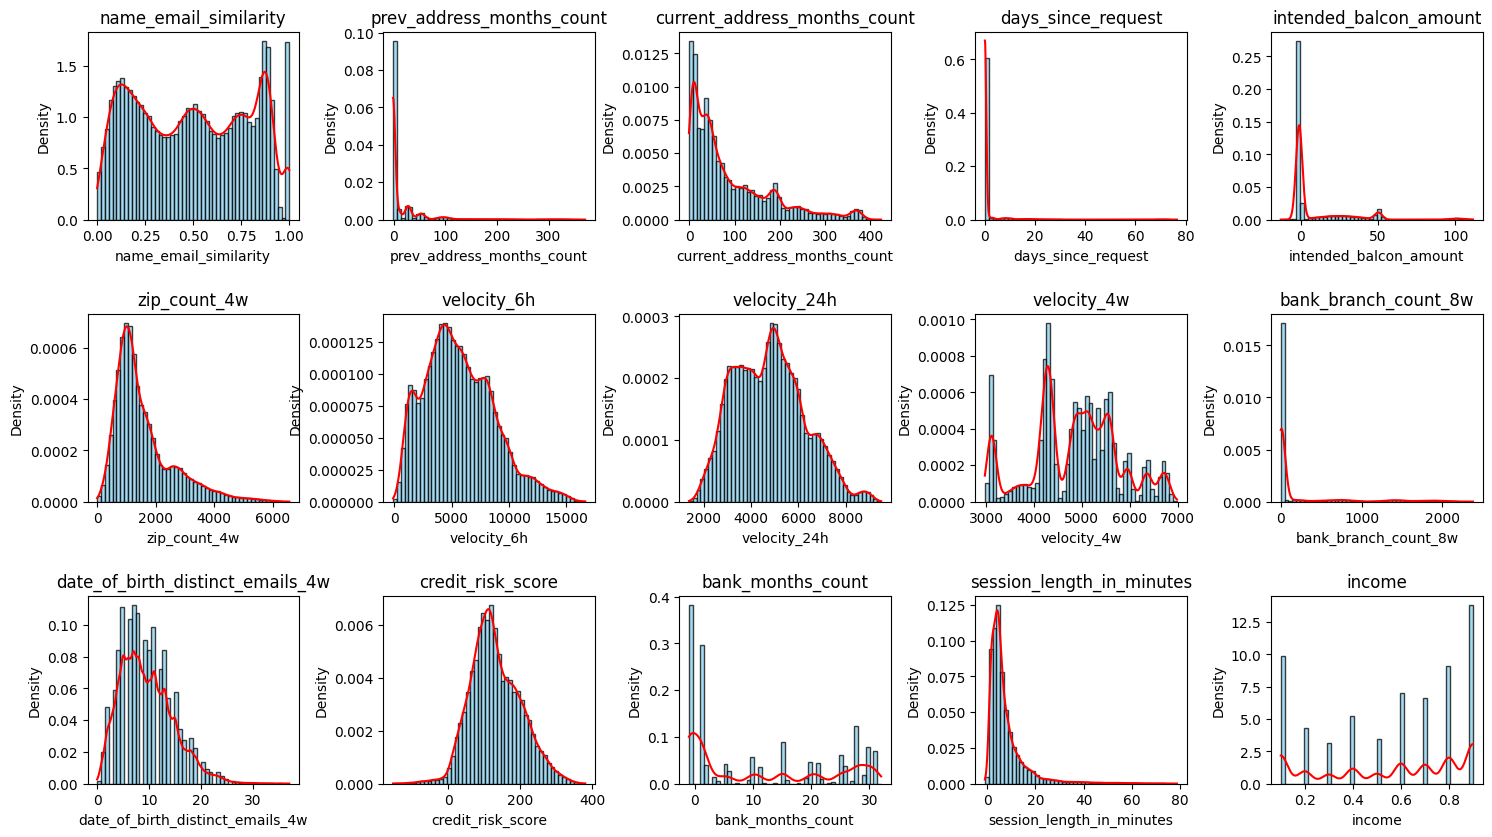

In [241]:
# create histogram with KDE plot for all teh numerical features
fig, ax = plt.subplots(3, 5, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(cont_feats):
    kde = stats.gaussian_kde(base_encoded[col])
    x = np.linspace(base_encoded[col].min(), base_encoded[col].max(), 1000)
    ax[i].plot(x, kde(x), color='red')
    ax[i].hist(base_encoded[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Density')

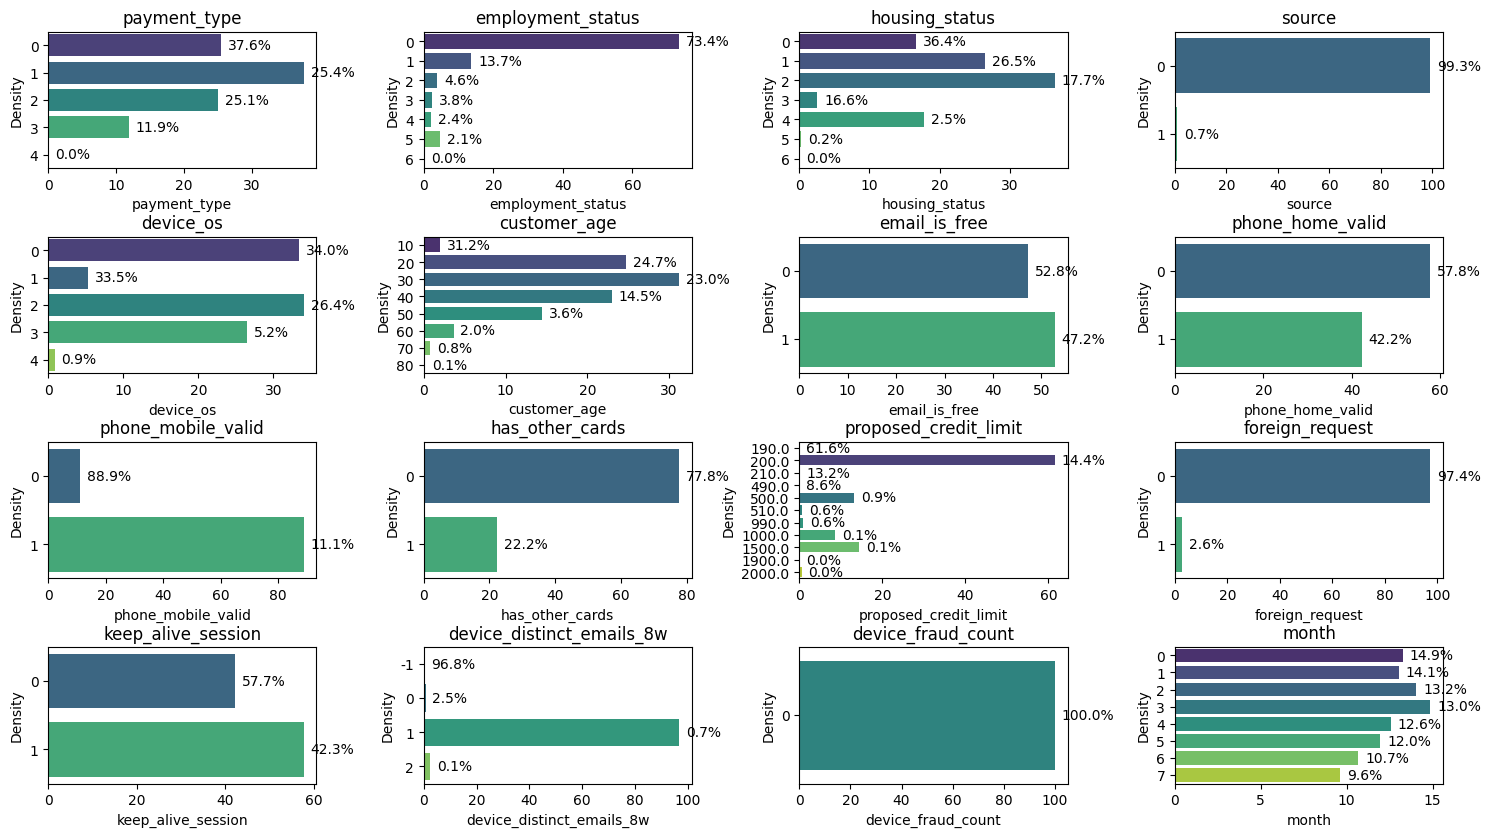

In [134]:
# create histogram with KDE plot for all teh numerical features
def eda_cat_feats(feats):
  fig, ax = plt.subplots(4, 4, figsize=(18, 8))
  plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
  ax = ax.flatten()
  for i,col in enumerate(feats):

      # Plotting horizontal bar plots on the first axis
      value_counts = base_encoded[col].value_counts()
      percent_total = value_counts / sum(value_counts) * 100
      bars = sns.barplot(x=percent_total.values, y=percent_total.index, ax=ax[i], palette='viridis', orient='h')

      # Annotating the bars with percentage values
      for bar, perc in zip(bars.patches, percent_total.values):
          ax[i].annotate(f'{perc:.1f}%',
                        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                        xytext=(5, 0),  # 5 points horizontal offset
                        textcoords='offset points',
                        ha='left', va='center')

      ax[i].set_title(f'{col}')
      ax[i].set_xlabel(col)
      ax[i].set_ylabel('Density')

eda_cat_feats (cat_feats+disc_feats)

## Feature Engineering

In [244]:
# drop high correlation and redundant features
# {'date_of_birth_distinct_emails_4w', 'velocity_24h', 'month', 'proposed_credit_limit', 'housing_status', 'velocity_4w', 'payment_type'}

drop_columns = ['month', 'velocity_4w', 'proposed_credit_limit']

for col in drop_columns:
    base_smote.drop(col, axis=1, inplace=True)
base_smote.head()

income  name_email_similarity prev_address_months_count  \
0     0.6               0.461974                      30.0   
1     0.9               0.388111                      31.0   
2     0.3               0.123415                       9.0   
3     0.2               0.069168                      21.0   
4     0.1               0.869321                      24.0   

  current_address_months_count  customer_age  days_since_request  \
0                          8.0            30            0.006326   
1                          2.0            50            0.010480   
2                         56.0            40            0.031242   
3                         39.0            30            0.000881   
4                         16.0            20            0.009921   

   intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
0               -0.916832             1          2162  1108.075600  ...   
1               -0.817218             1          2676  3849.725772  ...   
2               -1.623614             1           688  7503.932076  ...   
3               11.075005             0          1096  4052.377030  ...   
4               41.018283             1          1393  1586.570545  ...   

   bank_months_count  has_other_cards  foreign_request  source  \
0                1.0                0                0       0   
1               19.0                1                0       0   
2               20.0                0                0       0   
3                5.0                0                0       0   
4               15.0                0                0       0   

  session_length_in_minutes  device_os  keep_alive_session  \
0                   5.50275          0                   0   
1                  3.209488          3                   1   
2                  0.777212          3                   1   
3                 17.589304          3                   1   
4                  7.731688          2                   0   

   device_distinct_emails_8w  device_fraud_count fraud_bool  
0                        1.0                   0          0  
1                        1.0                   0          0  
2                        1.0                   0          0  
3                        1.0                   0          0  
4                        1.0                   0          0  

[5 rows x 29 columns]

In [245]:
# split dataset into train and test
X = base_smote.drop(target_feat, axis=1)
y = base_smote[target_feat]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y , test_size = 0.2)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(28137, 28)
(7035, 28)
(28137,)
(7035,)


## Classification Algorithms

### Clustering

Training Silhouette Score: 0.07306658763370334
Test Silhouette Score: 0.07128659757559384
Training Confusion Matrix:
[[3927 3969]
 [  70   34]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.50      0.66      7896
           1       0.01      0.33      0.02       104

    accuracy                           0.50      8000
   macro avg       0.50      0.41      0.34      8000
weighted avg       0.97      0.50      0.65      8000

Test Confusion Matrix:
[[ 952 1029]
 [   9   10]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.48      0.65      1981
           1       0.01      0.53      0.02        19

    accuracy                           0.48      2000
   macro avg       0.50      0.50      0.33      2000
weighted avg       0.98      0.48      0.64      2000



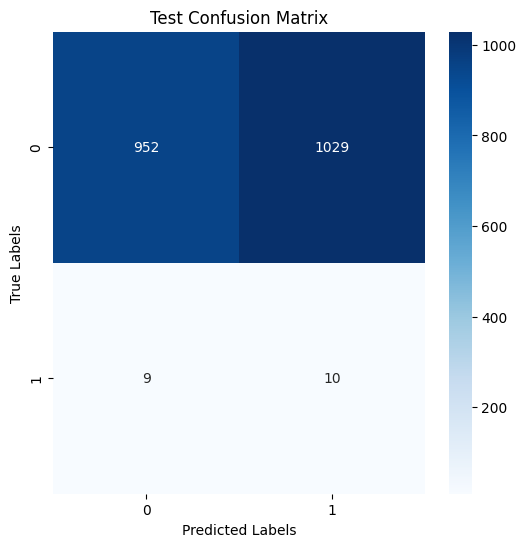

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_train_scaled)
clusters_test = kmeans.predict(X_test_scaled)

# Evaluate clustering performance on training data
sil_score_train = silhouette_score(X_train_scaled, clusters_train)
print(f'Training Silhouette Score: {sil_score_train}')

# Evaluate clustering performance on test data
sil_score_test = silhouette_score(X_test_scaled, clusters_test)
print(f'Test Silhouette Score: {sil_score_test}')

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels_train = np.zeros_like(clusters_train)
labels_train[clusters_train == 1] = 1

labels_test = np.zeros_like(clusters_test)
labels_test[clusters_test == 1] = 1

# Evaluate with confusion matrix and classification report on training data
cm_train = confusion_matrix(ytrain, labels_train)
cr_train = classification_report(ytrain, labels_train)

print('Training Confusion Matrix:')
print(cm_train)
print('\nTraining Classification Report:')
print(cr_train)

# Evaluate with confusion matrix and classification report on test data
cm_test = confusion_matrix(ytest, labels_test)
cr_test = classification_report(ytest, labels_test)

print('Test Confusion Matrix:')
print(cm_test)
print('\nTest Classification Report:')
print(cr_test)

# Plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
len(ytrain[ytrain[:]==1])

Training Silhouette Score: 0.06951799695566989
Test Silhouette Score: 0.07157739016713796
Training Confusion Matrix:
[[13149  2497]
 [ 2641  9850]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     15646
           1       0.80      0.79      0.79     12491

    accuracy                           0.82     28137
   macro avg       0.82      0.81      0.81     28137
weighted avg       0.82      0.82      0.82     28137

Test Confusion Matrix:
[[3289  605]
 [ 624 2517]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3894
           1       0.81      0.80      0.80      3141

    accuracy                           0.83      7035
   macro avg       0.82      0.82      0.82      7035
weighted avg       0.83      0.83      0.83      7035



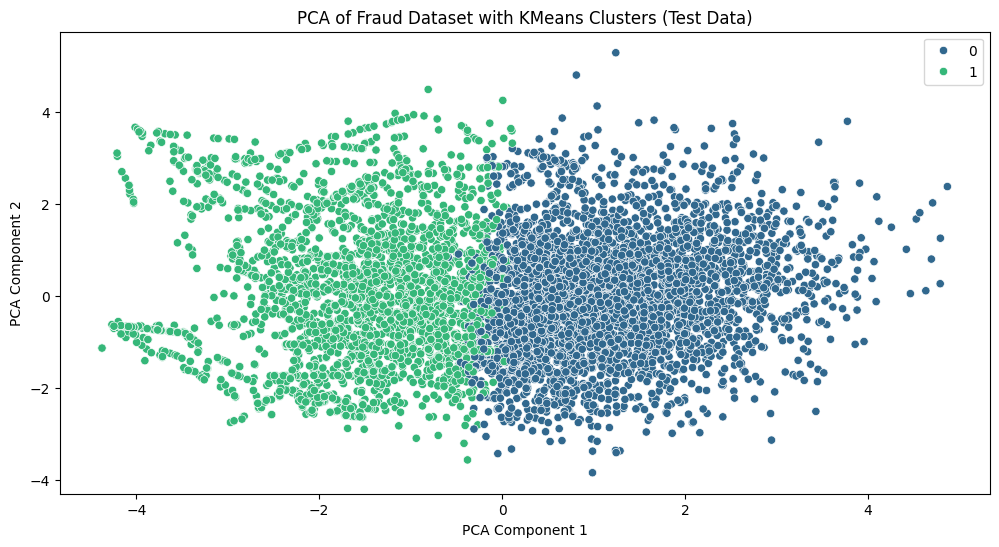

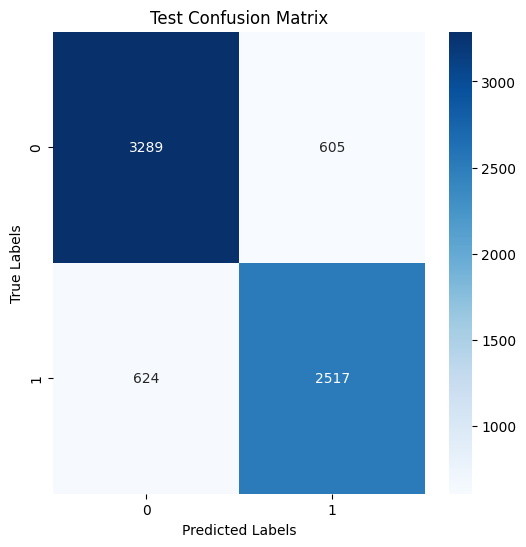

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_train_scaled)
clusters_test = kmeans.predict(X_test_scaled)

# Evaluate clustering performance on training data
sil_score_train = silhouette_score(X_train_scaled, clusters_train)
print(f'Training Silhouette Score: {sil_score_train}')

# Evaluate clustering performance on test data
sil_score_test = silhouette_score(X_test_scaled, clusters_test)
print(f'Test Silhouette Score: {sil_score_test}')

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels_train = np.zeros_like(clusters_train)
labels_train[clusters_train == 1] = 1

labels_test = np.zeros_like(clusters_test)
labels_test[clusters_test == 1] = 1

# Evaluate with confusion matrix and classification report on training data
cm_train = confusion_matrix(ytrain, labels_train)
cr_train = classification_report(ytrain, labels_train)

print('Training Confusion Matrix:')
print(cm_train)
print('\nTraining Classification Report:')
print(cr_train)

# Evaluate with confusion matrix and classification report on test data
cm_test = confusion_matrix(ytest, labels_test)
cr_test = classification_report(ytest, labels_test)

print('Test Confusion Matrix:')
print(cm_test)
print('\nTest Classification Report:')
print(cr_test)



# Plot PCA results with clusters for test data
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=clusters_test, palette='viridis', legend='full')
plt.title('PCA of Fraud Dataset with KMeans Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# Plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Anomaly Detection

In [114]:
def displayReport(clf_name, y, y_pred):
    # Adjust y_pred to match binary classification format
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print(f"{clf_name}: {n_errors}")
    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print('Classification Report: ')
    print(classification_report(y, y_pred))

In [115]:
# Define the parameter grid
param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1,2],
    'contamination': [0.05, 0.1]
}


# Define parameter grid for Isolation Forest
param_grid_if = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [False, True]
}

# Define parameter grid for OneClassSVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'nu': [0.01, 0.05, 0.1, 0.5]
}

# Custom scoring function
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == 1, 0, 1)
    return accuracy_score(y_true, y_pred)

# Make scorer
scorer = make_scorer(custom_scorer)

### Local Outlier Factor

#### Base Data

In [116]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(Xtest)
displayReport('Local Outlier', ytest, y_pred)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Local Outlier: 115
Accuracy Score :
0.9425
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1981
           1       0.02      0.11      0.03        19

    accuracy                           0.94      2000
   macro avg       0.51      0.53      0.50      2000
weighted avg       0.98      0.94      0.96      2000



#### After Data cleaning and preparation

In [ ]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(Xtest)
displayReport('Local Outlier', ytest, y_pred)

### Isolation Forest

In [118]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(Xtrain, ytrain)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(Xtest)
displayReport('Isolation Forest',ytest, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 39
Accuracy Score :
0.9805
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1981
           1       0.00      0.00      0.00        19

    accuracy                           0.98      2000
   macro avg       0.50      0.49      0.50      2000
weighted avg       0.98      0.98      0.98      2000



In [262]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(Xtrain, ytrain)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(Xtest)
displayReport('Isolation Forest',ytest, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 3190
Accuracy Score :
0.5465529495380241
Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.98      0.71      3894
           1       0.15      0.00      0.01      3141

    accuracy                           0.55      7035
   macro avg       0.35      0.49      0.36      7035
weighted avg       0.37      0.55      0.39      7035



In [120]:
# Standardize features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xtrain)
X_scaled_test = scaler.fit_transform(Xtest)


one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(X_scaled, ytrain)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(X_scaled_test)
displayReport('One class SVM',ytest, y_pred_svm)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid', 'nu': 0.01}
Best Score for OneClassSVM: 0.9808749999999999
One class SVM: 39
Accuracy Score :
0.9805
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1981
           1       0.00      0.00      0.00        19

    accuracy                           0.98      2000
   macro avg       0.50      0.49      0.50      2000
weighted avg       0.98      0.98      0.98      2000



In [263]:
# Standardize features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xtrain)
X_scaled_test = scaler.fit_transform(Xtest)


one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(X_scaled, ytrain)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(X_scaled_test)
displayReport('One class SVM',ytest, y_pred_svm)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.5}
Best Score for OneClassSVM: 0.5699607272227555
One class SVM: 2999
Accuracy Score :
0.5737029140014215
Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      3894
           1       0.52      0.58      0.55      3141

    accuracy                           0.57      7035
   macro avg       0.57      0.57      0.57      7035
weighted avg       0.58      0.57      0.57      7035



## Clustering

In [251]:
voting_clf = VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('svc', SVC(random_state=42))
            ]
        )
voting_clf.fit(Xtrain, ytrain)
for name, clf in voting_clf.named_estimators_.items():
        print(name, "=", clf.score(Xtest, ytest))

lr = 0.6966595593461266
rf = 0.997867803837953
svc = 0.7248045486851457


In [252]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Train the model (assuming GaussianNB for simplicity)
model = GaussianNB()
model.fit(X_train_scaled, ytrain)


GaussianNB()

In [253]:
y_pred = model.predict(X_test_scaled)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [254]:
print("Accuracy:", accuracy_score(ytest, y_pred))
print("Classification Report:\n", classification_report(ytest, y_pred))
print("ROC-AUC Score:", roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1]))


Accuracy: 0.6488983653162758
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.38      0.54      3894
           1       0.56      0.99      0.72      3141

    accuracy                           0.65      7035
   macro avg       0.77      0.68      0.63      7035
weighted avg       0.79      0.65      0.62      7035

ROC-AUC Score: 0.5


Important features in predicting fraud:


Text(0.5, 1.0, 'Feature Importance for Fraud Detection')

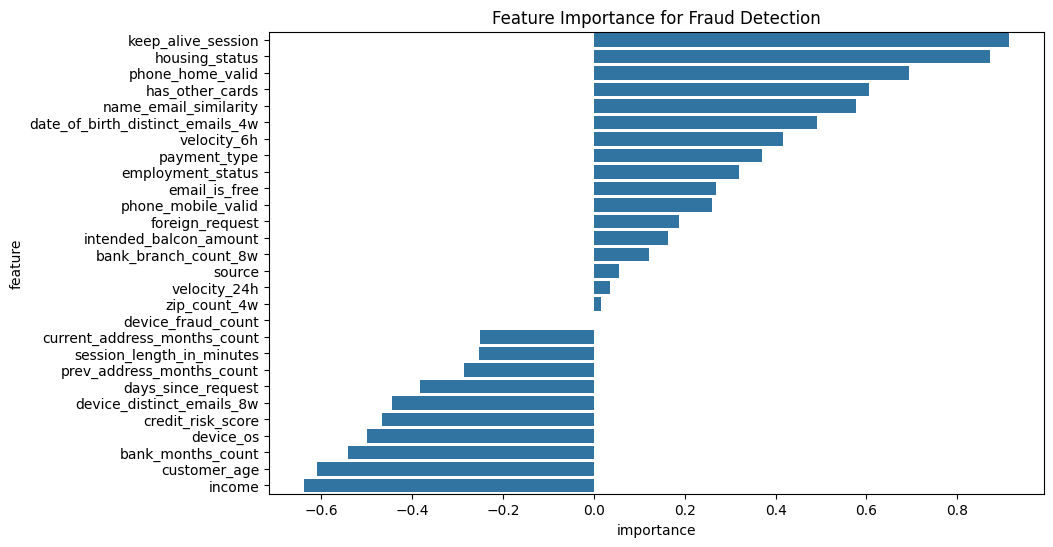

In [261]:
# Feature importance can be approximated by looking at the mean and variance of each feature for each class
featuresImp = pd.DataFrame()

# Initialize data lists
feature = []
importance = []

feature_importance = np.exp(model.theta_[0]) - np.exp(model.theta_[1])
important_features = np.argsort(feature_importance)[::-1]

print("Important features in predicting fraud:")
for i in important_features:
    feature.append(X.columns[i])
    importance.append(feature_importance[i])
    #print(X.columns[i], ":", feature_importance[i])

featuresImp['feature'] = feature
featuresImp['importance'] = importance

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=featuresImp.sort_values(by='importance', ascending=False))
plt.title('Feature Importance for Fraud Detection')

In [260]:
featuresImp

feature  importance
0                             income    0.638357
1                       customer_age    0.608887
2                  bank_months_count    0.542499
3                          device_os    0.500739
4                  credit_risk_score    0.466346
5          device_distinct_emails_8w    0.445566
6                 days_since_request    0.383205
7          prev_address_months_count    0.286022
8          session_length_in_minutes    0.253657
9       current_address_months_count    0.249864
10                device_fraud_count    0.000000
11                      zip_count_4w   -0.015758
12                      velocity_24h   -0.034734
13                            source   -0.055568
14              bank_branch_count_8w   -0.122221
15            intended_balcon_amount   -0.163245
16                   foreign_request   -0.187931
17                phone_mobile_valid   -0.260469
18                     email_is_free   -0.269216
19                 employment_status   -0.318551
20                      payment_type   -0.369381
21                       velocity_6h   -0.416997
22  date_of_birth_distinct_emails_4w   -0.491215
23             name_email_similarity   -0.576406
24                   has_other_cards   -0.604992
25                  phone_home_valid   -0.693027
26                    housing_status   -0.872144
27                keep_alive_session   -0.912772